# ***Lab 4 - Linear models***

In [1]:
import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from cmdstanpy import CmdStanModel

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Normal model - no predictors

In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d = d[d.age >= 18] # Just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
height_mu = np.mean(d.height)
height_std = np.std(d.height)
print(f"Mean height: {height_mu}\nStandard deviation of height: {height_std}")

Mean height: 154.5970926136364
Standard deviation of height: 7.73132668454304


## Task 1. Prior predictive checks

In [4]:
model_ppc = CmdStanModel(stan_file="height_1_ppc.stan")

INFO:cmdstanpy:compiling stan file /home/Lab4/height_1_ppc.stan to exe file /home/Lab4/height_1_ppc


: 

In [11]:
R = 1000
mu_mu, mu_sig, sig_lbd = 175, 15, 0.07
sim = model_ppc.sample(data={"mu_mu": mu_mu, "mu_sig": mu_sig, "sig_lbd": sig_lbd}, iter_sampling=R, iter_warmup=0, chains=1, fixed_param=True, seed=29042020, refresh=R)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [ ]:
sim_pd = sim.draw_pd()
sim_pd.head()

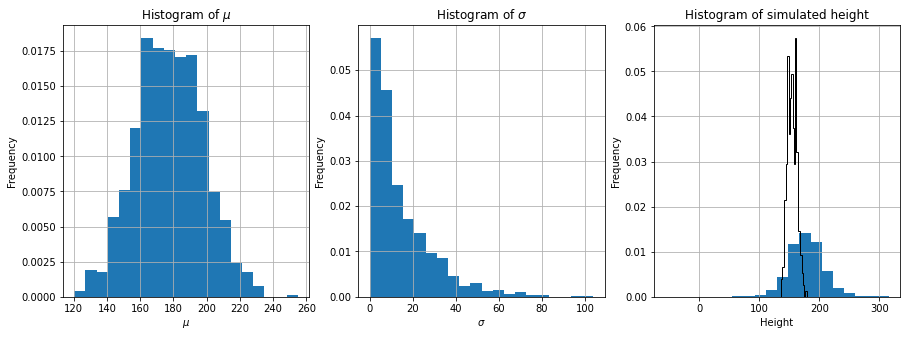

In [15]:
_, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.histplot(data=sim_pd, x="mu", stat="density", ax=ax[0], bins=30)
sns.histplot(data=sim_pd, x="sig", stat="density", ax=ax[1], bins=30)
sns.histplot(data=sim_pd, x="height", stat="density", ax=ax[1], bins=30)
ax[0].axvline(np.mean(sim_pd.mu), color="red")
ax[2].axvline(np.mean(sim_pd.height), color="red")
ax[1].set_xlabel("$\sigma$")
plt.title("Histograms")
plt.show()

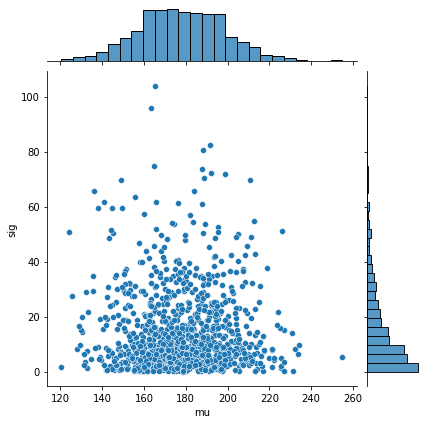

In [17]:
sns.jointplot(data=sim_pd, x="mu", y="sig", alpha=0.5)
plt.show()

In [ ]:
height_prior = np.random.normal(175, 15, size=R)

plt.figure(figsize=(5, 5))
plt.hist(height_prior, bins=30, alph=0.7, density=True, label="Prior")
plt.hist(sim_pd.height, bins=30, alpha=0.7, density=True, label="Posterior")
plt.xlabel("Height")
plt.ylabel("Density")
plt.legend()
plt.show()

**Observed data is possible to obtain using priors.**

## Task 2. Model fit and evaluation

In [20]:
model_1_fit=CmdStanModel(stan_file="height_1_fit.stan")

INFO:cmdstanpy:compiling stan file /home/Lab4/height_1_fit.stan to exe file /home/Lab4/height_1_fit
INFO:cmdstanpy:compiled model executable: /home/Lab4/height_1_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/Lab4/height_1_fit.hpp /home/Lab4/height_1_fit.stan
Warning in '/home/Lab4/height_1_fit.stan', line 3, column 2: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math/lib/sundials_6.0.0/include -I stan/lib/stan_math/lib/sund

In [22]:
fit = model_1_fit.sample(data={"N": len(d), "heights": d.height.values}, seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


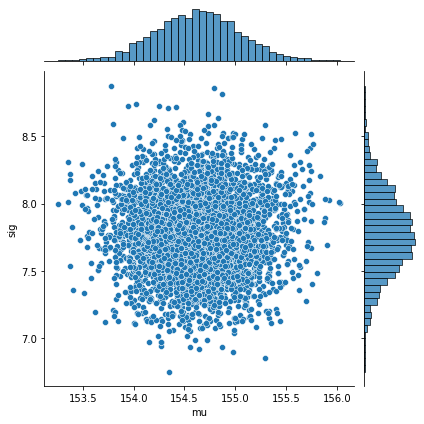

In [23]:
fit_pd = fit.draws_pd()
fit_pd.head()

In [ ]:
sns.jointplot(data=fit_pd, x="mu", y="sig", alpha=0.2)
plt.show()

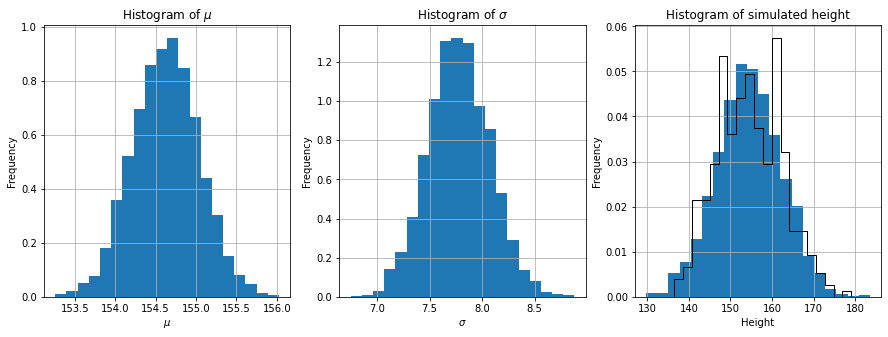

In [27]:
plt.figure(figsize=(5, 5))
plt.hist(d.height, bins=30, alpha=0.7, density=true, label="Original height")
plt.hist(fit_pd.height, bins=30, alpha=0.7, density=true, label="Simulated height")
plt.legend()
plt.show()

**The model fits the data pretty well.**

## Task 3. Adding predictor to the model - weight

In [28]:
d["c_weight"] = d.weight - d.weight.mean()
data_sim={"N": 50, "weight": np.linspace(d.c_weight.min(), d.weight.max())}
data_sim.head()

{'N': 50,
 'weight': array([0.69061384, 0.70509379, 0.71957374, 0.73405369, 0.74853364,
        0.76301359, 0.77749354, 0.79197348, 0.80645343, 0.82093338,
        0.83541333, 0.84989328, 0.86437323, 0.87885318, 0.89333313,
        0.90781308, 0.92229303, 0.93677297, 0.95125292, 0.96573287,
        0.98021282, 0.99469277, 1.00917272, 1.02365267, 1.03813262,
        1.05261257, 1.06709252, 1.08157247, 1.09605241, 1.11053236,
        1.12501231, 1.13949226, 1.15397221, 1.16845216, 1.18293211,
        1.19741206, 1.21189201, 1.22637196, 1.24085191, 1.25533185,
        1.2698118 , 1.28429175, 1.2987717 , 1.31325165, 1.3277316 ,
        1.34221155, 1.3566915 , 1.37117145, 1.3856514 , 1.40013134])}

## Task 4. Prior predictive checks

In [29]:
model_ppc = CmdStanModel(stan_file="height_2a_ppc.stan")

INFO:cmdstanpy:compiling stan file /home/Lab4/height_2a_ppc.stan to exe file /home/Lab4/height_2a_ppc
INFO:cmdstanpy:compiled model executable: /home/Lab4/height_2a_ppc
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/Lab4/height_2a_ppc.hpp /home/Lab4/height_2a_ppc.stan
Warning in '/home/Lab4/height_2a_ppc.stan', line 3, column 2: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/home/Lab4/height_2a_ppc.stan', line 9, column 2: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored

In [30]:
R = 1000
sim = model_ppc.sample(data=data_sim, iter_sampling=R, iter_warmup=0, chains=1, refresh=R, fixed_param=True, seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [ ]:
sim_pd = sim.draws_pd()
sim_pd.head()

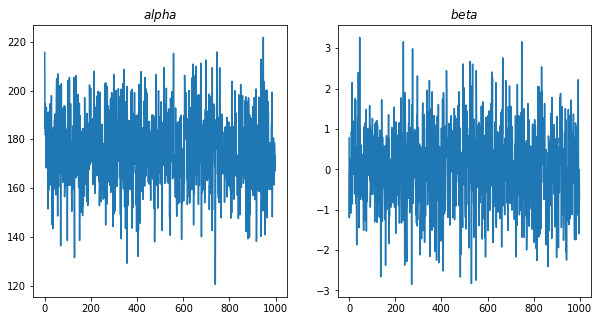

Maximum alpha value is: 221.805


In [33]:
alpha_samples = sim_pd.alpha.values
beta_samples = sim_pd.beta_.values

for i in range(len(alpha_samples)):
    plt.plot(data_sim.weight, beta_samples[i] * data_sim.weight + alpha_samples[i], color="gray", alpha=0.1)

plt.axhline(y=0, ls="--")
plt.axhline(y=270, ls="--")

plt.xlabel("Weight")
plt.ylabel("Height")
plt.show()

## Task 5. Modifying prior

In [ ]:
model_ppc = CmdStanModel(stan_file="height_2b_ppc.stan")

In [ ]:
R = 1000
sim = model_ppc.sample(data=data_sim, iter_sampling=R, iter_warmup=0, chains=1, refresh=R, fixed_param=True, seed=29042020)

In [ ]:
sim_pd = sim.draws_pd()
sim_pd.head()

In [ ]:
alpha_samples = sim_pd.alpha.values
beta_samples = sim_pd.beta_.values

for i in range(len(alpha_samples)):
    plt.plot(data_sim.weight, beta_samples[i] * data_sim.weight + alpha_samples[i], color="gray", alpha=0.1)

plt.axhline(y=0, ls="--")
plt.axhline(y=270, ls="--")

plt.xlabel("Weight")
plt.ylabel("Height")
plt.show()

## Task 6. Fitting and evaluating model

## Task 7. Extending the model